In [117]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('notebook')

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from timeit import default_timer as timer

In [118]:
murders = pd.read_csv('C:\\Users\\Classy\\Desktop\\murders_short.csv')
murders_no_unknowns = pd.read_csv('C:\\Users\\Classy\\Desktop\\murders_no_unknowns.csv')
murders_unknown_ethnic = pd.read_csv('C:\\Users\\Classy\\Desktop\\murders_no_unknowns_except_VicEthnic.csv')

In [119]:
murders.Solved.value_counts()

Yes    568026
No     236692
Name: Solved, dtype: int64

In [120]:
murders_no_unknowns.Solved.value_counts()

Yes    220148
No      88813
Name: Solved, dtype: int64

In [121]:
murders_unknown_ethnic.Solved.value_counts()

Yes    534574
No     212330
Name: Solved, dtype: int64

Models using no_unknowns (smallest and cleanest) dataset:

In [122]:
murders_no_unknowns.nunique()

Unnamed: 0            308961
Ori                     9103
Agentype                   7
Solved                     2
Month                     12
Homicide                   2
Situation                  2
VicAge                   100
VicSex                     2
VicRace                    5
VicEthnic                  2
Weapon                    12
VicCount                  11
MSA                      407
OriClearance            1318
OriCases                 541
WhiteNonWhiteRatio      1668
AgeKnown                   1
dtype: int64

In [123]:
# Balance

solved_count, unsolved_count = murders_no_unknowns.Solved.value_counts()
solved = murders_no_unknowns[murders_no_unknowns.Solved == 'Yes']
unsolved = murders_no_unknowns[murders_no_unknowns.Solved == 'No']
solved_sample = solved.sample(unsolved_count)

murders_no_unknowns = pd.concat([unsolved, solved_sample], axis = 0)

murders_no_unknowns.Solved.value_counts()

Yes    88813
No     88813
Name: Solved, dtype: int64

In [124]:
start_preprocessing = timer()

#Create dummy columns for categorical features
model_df = pd.get_dummies(murders_no_unknowns[['Agentype',
                                   'Month',
                                   'Homicide',
                                   'Situation',
                                   'VicSex',
                                   'VicRace',
                                   'VicEthnic',
                                   'Weapon',
                                   'MSA']],
                          drop_first=True)

#Add numerical features to model dataframe
model_df['VicAge'] = murders_no_unknowns.VicAge
model_df['VicCount'] = murders_no_unknowns.VicCount
#model_df['OriClearance'] = murders_no_unknowns.OriClearance
model_df['OriCases'] = murders_no_unknowns.OriCases
model_df['WhiteNonWhiteRatio'] = murders_no_unknowns.WhiteNonWhiteRatio


print(model_df.columns)


Index(['Agentype_Municipal police', 'Agentype_Primary state LE',
       'Agentype_Regional police', 'Agentype_Sheriff',
       'Agentype_Special police', 'Agentype_Tribal', 'Month_August',
       'Month_December', 'Month_February', 'Month_January',
       ...
       'MSA_Worcester, MA', 'MSA_Yakima, WA', 'MSA_York-Hanover, PA',
       'MSA_Youngstown-Warren-Boardman, OH-PA', 'MSA_Yuba City, CA',
       'MSA_Yuma, AZ', 'VicAge', 'VicCount', 'OriCases', 'WhiteNonWhiteRatio'],
      dtype='object', length=444)


In [125]:
#Encode prediction variable and add to dataframe
ord_enc = OrdinalEncoder().fit(murders_no_unknowns[['Solved']])
model_df['Solved']= ord_enc.transform(murders_no_unknowns[['Solved']]).reshape(-1,1)

print(model_df.columns)
model_df.head()

Index(['Agentype_Municipal police', 'Agentype_Primary state LE',
       'Agentype_Regional police', 'Agentype_Sheriff',
       'Agentype_Special police', 'Agentype_Tribal', 'Month_August',
       'Month_December', 'Month_February', 'Month_January',
       ...
       'MSA_Yakima, WA', 'MSA_York-Hanover, PA',
       'MSA_Youngstown-Warren-Boardman, OH-PA', 'MSA_Yuba City, CA',
       'MSA_Yuma, AZ', 'VicAge', 'VicCount', 'OriCases', 'WhiteNonWhiteRatio',
       'Solved'],
      dtype='object', length=445)


,Agentype_Municipal police,Agentype_Primary state LE,Agentype_Regional police,Agentype_Sheriff,Agentype_Special police,Agentype_Tribal,Month_August,Month_December,Month_February,Month_January,...,"MSA_Yakima, WA","MSA_York-Hanover, PA","MSA_Youngstown-Warren-Boardman, OH-PA","MSA_Yuba City, CA","MSA_Yuma, AZ",VicAge,VicCount,OriCases,WhiteNonWhiteRatio,Solved
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,29.0,0,879,0.524460,0.0
14,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,44.0,0,147,0.557823,0.0
15,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,35.0,0,147,0.557823,0.0
21,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,43.0,0,147,0.557823,0.0
30,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,34.0,1,38,0.552632,0.0


In [126]:
#Create scaled training and validation datasets
X = model_df.drop('Solved', axis=1)
X = StandardScaler().fit_transform(X)
y = model_df.Solved

X_train, X_validation, y_train, y_validation = train_test_split(X, y, stratify = y, random_state = 33)

end_preprocessing = timer()
print('Preprocessing Time:', round(end_preprocessing - start_preprocessing,1), 'seconds')

Preprocessing Time: 21.8 seconds


In [127]:
#Logistic Regression Model Cross Validation
start_cross_val = timer()

logreg = LogisticRegression(max_iter = 1000)
logreg_scores = cross_val_score(logreg, X_train, y_train)

print('Mean Accuracy:',round(logreg_scores.mean()*100,2),'%')
print('Accuracy Standard Deviation',round(logreg_scores.std()*100,2),'%')

end_cross_val = timer()
print('Cross Validation Time:', round(end_cross_val - start_cross_val,1), 'seconds')

Mean Accuracy: 64.96 %
Accuracy Standard Deviation 0.38 %
Cross Validation Time: 41.8 seconds


Training Time: 9.2 seconds
Prediction Time: 0.1 seconds
Confusion Matrix:
 [[15794  6410]
 [ 9159 13044]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.71      0.67     22204
         1.0       0.67      0.59      0.63     22203

    accuracy                           0.65     44407
   macro avg       0.65      0.65      0.65     44407
weighted avg       0.65      0.65      0.65     44407

Accuracy: 64.94 %


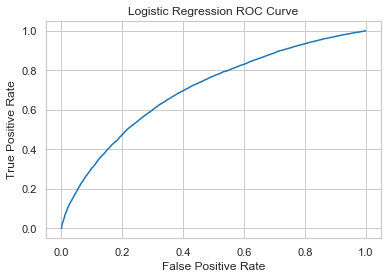

Reporting Time: 1.0 seconds


In [129]:
#Train Single Logistic Regression Model
start_training = timer()

logreg = LogisticRegression(max_iter = 1000).fit(X_train, y_train)

end_training = timer()
print('Training Time:', round(end_training - start_training,1), 'seconds')

#Use trained model to predict test results
start_prediction = timer()

y_pred = logreg.predict(X_validation)
y_pred_prob = logreg.predict_proba(X_validation)[:,1]

end_prediction = timer()
print('Prediction Time:', round(end_prediction - start_prediction,1), 'seconds')

#Output test reports
start_reports = timer()

print('Confusion Matrix:\n', confusion_matrix(y_validation, y_pred))
print('Classification Report:\n', classification_report(y_validation, y_pred))
print('Accuracy:', round(logreg.score(X_validation, y_validation) *100,2), "%")

fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

end_reports = timer()
print('Reporting Time:', round(end_reports - start_reports,1), 'seconds')

                                                  0         1
0                    MSA_Los Angeles-Long Beach, CA -0.550069
1        MSA_New York-New Jersey-Long Island, NY-NJ -0.292129
2             MSA_San Francisco-Oakland-Fremont, CA -0.279098
3               MSA_Dallas-Fort Worth-Arlington, TX -0.232612
4    Homicide_Murder and non-negligent manslaughter -0.217719
..                                              ...       ...
439                              MSA_Tuscaloosa, AL  0.133140
440       Weapon_Personal weapons, includes beating  0.133893
441              Weapon_Knife or cutting instrument  0.152756
442                VicEthnic_Not of Hispanic origin  0.181630
443                              WhiteNonWhiteRatio  0.346598

[444 rows x 2 columns]


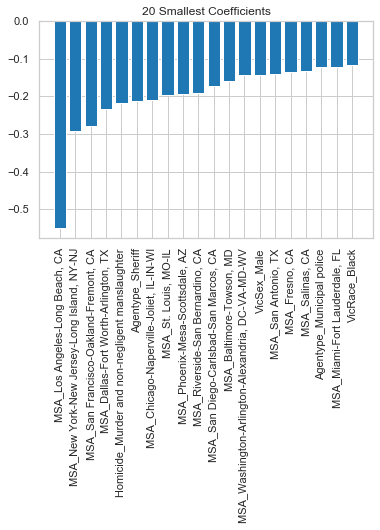

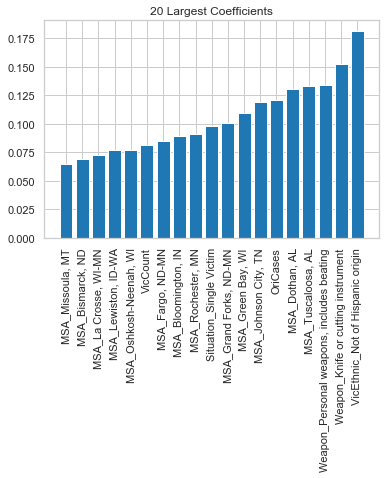

In [130]:
coef_df = pd.DataFrame(zip(model_df.drop('Solved', axis = 1).columns,logreg.coef_[0]))
coef_df.sort_values(1, inplace = True)
coef_df.reset_index(inplace = True, drop = True)

print(coef_df)

plt.bar(coef_df[0][0:20],coef_df[1][0:20])
plt.xticks(rotation = 'vertical')
plt.title('20 Smallest Coefficients')
plt.show()

plt.bar(coef_df[0][-20:-1],coef_df[1][-20:-1])
plt.xticks(rotation = 'vertical')
plt.title('20 Largest Coefficients')
plt.show()

In [ ]:
#Lowest coefficients charts won't print lowest variable, which is 'WhiteNonWhiteRatio'

In [ ]:
#Kneighbors, Decision Tree, Naive Bayes, SVC